Consider the general equation
\\[ -\mathrm{div}(A \ \mathrm{grad}(w)) + b \cdot \mathrm{grad}(w) + c\ w = 1. \\]

In [1]:
import numpy as np
import sys

sys.path.insert(1, "/Users/gpin/Repos/EVErrorEst/scripts")
from ngsolve import *
from main_utils import *
from ngsolve.webgui import Draw
import matplotlib.pyplot as plt

# Adaptivity

In [9]:
ORDER = 2
MAXITER = 25
THETA = 0.9

CENTER = 5 * np.pi**2 + 325
RADIUS = 10.0
NPTS = 6
NSPAN = 2

MAXH = 0.1

## System 1
Consider
\\[ \mathcal{L} w := -\Delta\ w + (20,30) \cdot \mathrm{grad}(w)  = 1,\\]
with a residual error estimator based on the landscape function.

It has the form
\\[\eta^2_K = \lVert -\Delta\ w + (20,30) \cdot \mathrm{grad}(w) - 1\rVert_K^2
    + \frac{1}{2} h_k \lVert \partial_\nu w \rVert_{\partial K}^2. \\]


In [10]:
matrix = CoefficientFunction((1, 0, 0, 1), dims=(2, 2))
vector = CoefficientFunction((20, 30))
scalar = CoefficientFunction(0.0)
mesh = Mesh(make_unit_square().GenerateMesh(maxh=MAXH))
Draw(mesh)

eta_dict = {}
eig_dict = {}
err_dict = {}
prev_avg_eig = CENTER
iteration = 0
while iteration < MAXITER:
    iteration += 1
    a, m, f, fes = get_forms(
        mesh,
        matrix_coeff=matrix,
        vector_coeff=vector,
        scalar_coeff=scalar,
        order=ORDER,
        is_complex=True,
    )
    u = solve(a, f, fes)
    _, _, evals = solve_eigenvalue(a, m, fes, center=CENTER)
    eta, _, _ = error_estimator_landscape(
        u, matrix_coeff=matrix, vector_coeff=vector, scalar_coeff=scalar
    )
    append_to_dict(
        eta_dict,
        ndofs=fes.ndof,
        eta_avg=np.mean(eta),
        eta_l2=np.linalg.norm(eta),
        eta_max=np.max(eta),
    )
    append_to_dict(
        eig_dict,
        ndofs=fes.ndof,
        avg_evals=np.mean(evals),
        avg_evals_real=np.real(np.mean(evals)),
        avg_evals_imag=np.imag(np.mean(evals)),
    )
    append_to_dict(
        err_dict,
        ndofs=fes.ndof,
        error_avg=np.absolute(np.mean(evals) - CENTER),
        error_cauchy=np.absolute(np.mean(evals) - prev_avg_eig),
        error_relative=np.absolute(np.mean(evals) - CENTER) / np.absolute(CENTER),
        error_cauchy_relative=np.absolute(np.mean(evals) - prev_avg_eig)
        / np.absolute(prev_avg_eig),
    )
    prev_avg_eig = np.mean(evals)
    # Mark
    mark(mesh, eta, theta=THETA)
    # Refine
    mesh.Refine()

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…


SpectralProj: Setting shifted trapezoidal rule quadrature on circular contour
SpectralProj: Radius=0.01, Center=374.348+0j

SpectralProjNG: Computing resolvents using umfpack
SpectralProjNG:   Factorizing at z = +374.355 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 -0.007j
SpectralProjNG:   Factorizing at z = +374.355 -0.007j

=========== Starting FEAST iterations ===========
Trying with 2 vectors:

 ITERATION 1 with 2 vectors and 2 left vectors
   During kernel cleaning abs(g):
   [1.9e-16 3.8e-10]
   Real part of computed eigenvalues:
   [373.93664014 376.17301055]
   Imag part of computed eigenvalues:
   [-1.14895821e-13 -3.16204655e-09]
   Relative Hausdorff distance from prior iterate: 2.671e+97

 ITERATION 2 with 2 vectors and 2 left vectors
   During kernel cleaning abs(g):
   [1.3e-05 3.1e-04]
   Real part of computed eigenvalues:
   [373.93664014 376.17301055]
   Relative Hausdorff distance from prior iterate: 1.9

In [11]:
Draw(u, mesh, name="Landscape function")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [12]:
to_file(eta_dict, "etas_original_problem.csv")
to_file(eig_dict, "eval_original_problem.csv")
to_file(err_dict, "errs_original_problem.csv")
eta_df = pd.DataFrame(eta_dict)
eig_df = pd.DataFrame(eig_dict)
err_df = pd.DataFrame(err_dict)

<Axes: xlabel='ndofs'>

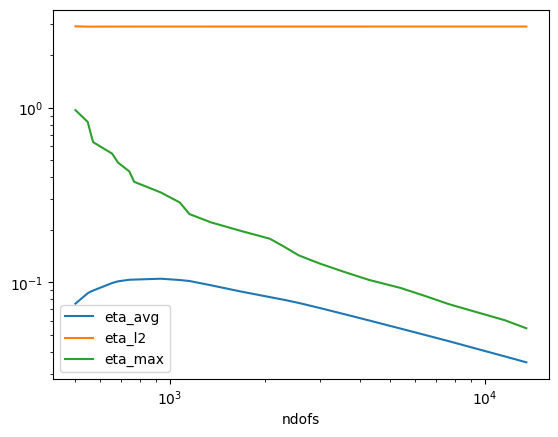

In [13]:
eta_df.plot(x="ndofs", loglog=True)

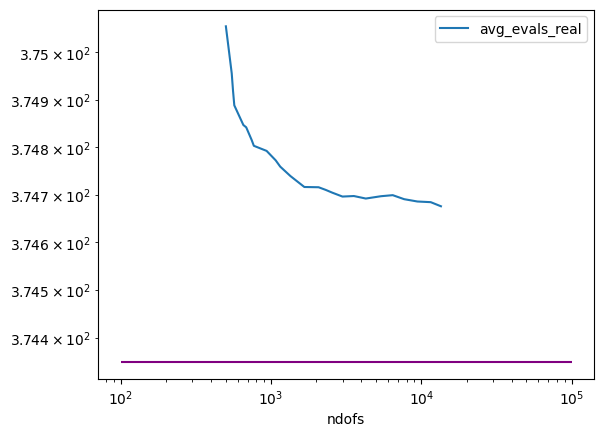

In [14]:
ax = eig_df.drop(["avg_evals", "avg_evals_imag"], axis=1).plot(x="ndofs", loglog=True)
ax.hlines(y=CENTER, xmin=100, xmax=100000, color="purple", label="test")

<Axes: xlabel='ndofs'>

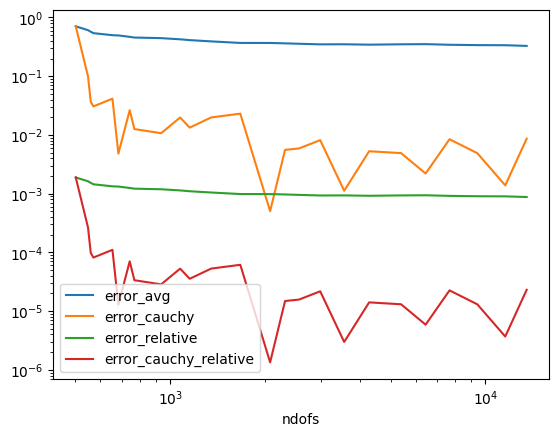

In [15]:
err_df.plot(x="ndofs", loglog=True)

## System 2

Consider
\\( \tilde {\mathcal{L}} w := \exp(-\phi) \mathcal{L} \exp{\phi}\\).
This is,
\\[ -\Delta\ w + \frac{20^2 + 30^2}{4} w  = 1,\\]
with a residual error estimator based on the landscape function.

It has the form
\\[\eta^2_K = \lVert -\Delta\ w + \frac{20^2 + 30^2}{4} w - 1\rVert_K^2
    + \frac{1}{2} \lVert \partial_\nu w \rVert_{\partial K}^2. \\]


In [16]:
matrix = CoefficientFunction((1.0, 0.0, 0.0, 1.0), dims=(2, 2))
vector = CoefficientFunction((0.0, 0.0))
scalar = CoefficientFunction(325.0)
mesh = Mesh(make_unit_square().GenerateMesh(maxh=MAXH))
Draw(mesh)

eta_dict = {}
eig_dict = {}
err_dict = {}
prev_avg_eig = CENTER
iteration = 0
while iteration < MAXITER:
    iteration += 1
    a, m, f, fes = get_forms(
        mesh,
        matrix_coeff=matrix,
        vector_coeff=vector,
        scalar_coeff=scalar,
        order=ORDER,
        is_complex=True,
    )
    u = solve(a, f, fes)
    _, _, evals = solve_eigenvalue(a, m, fes, center=CENTER)
    eta, _, _ = error_estimator_landscape(
        u, matrix_coeff=matrix, vector_coeff=vector, scalar_coeff=scalar
    )
    append_to_dict(
        eta_dict,
        ndofs=fes.ndof,
        eta_avg=np.mean(eta),
        eta_l2=np.linalg.norm(eta),
        eta_max=np.max(eta),
    )
    append_to_dict(
        eig_dict,
        ndofs=fes.ndof,
        avg_evals=np.mean(evals),
        avg_evals_real=np.real(np.mean(evals)),
        avg_evals_imag=np.imag(np.mean(evals)),
    )
    append_to_dict(
        err_dict,
        ndofs=fes.ndof,
        error_avg=np.absolute(np.mean(evals) - CENTER),
        error_cauchy=np.absolute(np.mean(evals) - prev_avg_eig),
        error_relative=np.absolute(np.mean(evals) - CENTER) / np.absolute(CENTER),
        error_cauchy_relative=np.absolute(np.mean(evals) - prev_avg_eig)
        / np.absolute(prev_avg_eig),
    )
    prev_avg_eig = np.mean(evals)
    # Mark
    mark(mesh, eta, theta=THETA)
    # Refine
    mesh.Refine()

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…


SpectralProj: Setting shifted trapezoidal rule quadrature on circular contour
SpectralProj: Radius=0.01, Center=374.348+0j

SpectralProjNG: Computing resolvents using umfpack
SpectralProjNG:   Factorizing at z = +374.355 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 -0.007j
SpectralProjNG:   Factorizing at z = +374.355 -0.007j

=========== Starting FEAST iterations ===========
Trying with 2 vectors:

 ITERATION 1 with 2 vectors and 2 left vectors
   During kernel cleaning abs(g):
   [3.2e-05 6.8e-04]
   Real part of computed eigenvalues:
   [374.35759663 374.35851288]
   Relative Hausdorff distance from prior iterate: 2.671e+97

 ITERATION 2 with 2 vectors and 2 left vectors
   During kernel cleaning abs(g):
   [3783.4  323.1]
   Real part of computed eigenvalues:
   [374.35759663 374.35851288]
   Relative Hausdorff distance from prior iterate: 1.216e-15


***FEAST converged with:
	Relative Hausdorff distance = 1.216e-15

=

In [17]:
Draw(u, mesh, name="Landscape function")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [18]:
to_file(eta_dict, "etas_mod_problem.csv")
to_file(eig_dict, "eval_mod_problem.csv")
to_file(err_dict, "errs_mod_problem.csv")
eta_df = pd.DataFrame(eta_dict)
eig_df = pd.DataFrame(eig_dict)
err_df = pd.DataFrame(err_dict)

<Axes: xlabel='ndofs'>

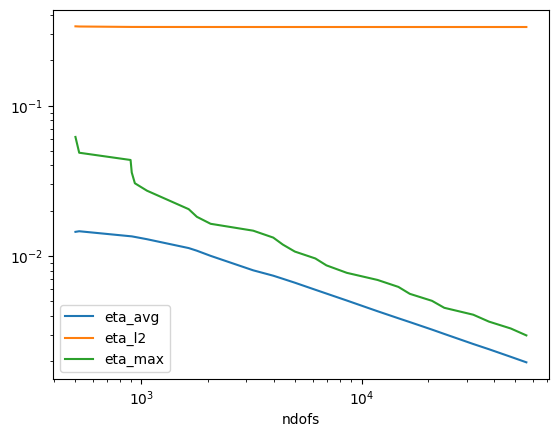

In [19]:
eta_df.plot(x="ndofs", loglog=True)

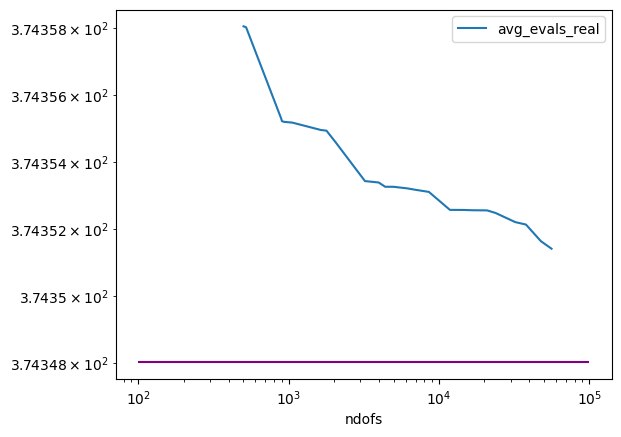

In [20]:
ax = eig_df.drop(["avg_evals", "avg_evals_imag"], axis=1).plot(x="ndofs", loglog=True)
ax.hlines(y=CENTER, xmin=100, xmax=100000, color="purple", label="test")

<Axes: xlabel='ndofs'>

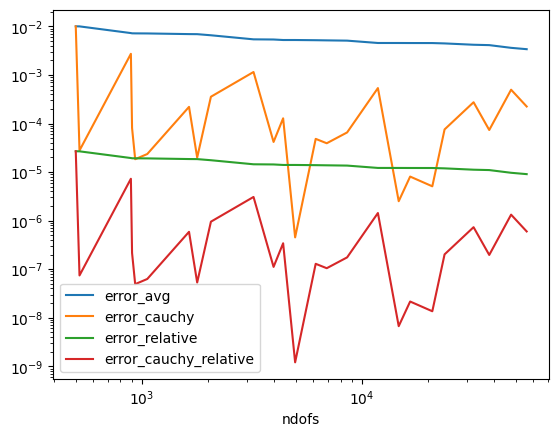

In [21]:
err_df.plot(x="ndofs", loglog=True)

## System 3

### FEAST
Consider the eigenvalue problem
\\[ \mathcal{L} w := -\Delta\ w + (20,30) \cdot \mathrm{grad}(w)  = \lambda w,\\]
with a residual error estimator based on the eigenfunctions.

They have the form
\\[\eta^2_K(w_i, \lambda_i) = \lVert -\Delta\ w_i+ (20,30) \cdot \mathrm{grad}(w_i) - \lambda_i w_i\rVert_K^2
    + \frac{1}{2} \lVert \partial_\nu w \rVert_{\partial K}^2. \\]


In [22]:
matrix = CoefficientFunction((1, 0, 0, 1), dims=(2, 2))
vector = CoefficientFunction((20, 30))
scalar = CoefficientFunction(0.0)
mesh = Mesh(make_unit_square().GenerateMesh(maxh=MAXH))
Draw(mesh)

eta_dict = {}
eig_dict = {}
err_dict = {}
prev_avg_eig = CENTER
iteration = 0
while iteration < MAXITER:
    iteration += 1
    a, m, f, fes = get_forms(
        mesh,
        matrix_coeff=matrix,
        vector_coeff=vector,
        scalar_coeff=scalar,
        order=ORDER,
        is_complex=True,
    )
    right, _, evals = solve_eigenvalue(a, m, fes, center=CENTER)
    etas = []
    for k in range(right.m):
        eta, _, _ = error_estimator_landscape(
            right[k],
            matrix_coeff=matrix,
            vector_coeff=vector,
            scalar_coeff=scalar,
            source_coeff=evals[k] * right[k],
        )
        etas.append(eta)
    stacked_etas = np.stack(etas)
    average_etas = np.mean(stacked_etas, axis=0)
    maximum_etas = np.maximum.reduce(stacked_etas)
    append_to_dict(
        eta_dict,
        ndofs=fes.ndof,
        eta_avg_avg=np.mean(average_etas),
        eta_avg_max=np.max(average_etas),
        eta_avg_l2=np.linalg.norm(eta),
        eta_max_avg=np.mean(maximum_etas),
        eta_max_max=np.max(maximum_etas),
        eta_max_l2=np.linalg.norm(eta),
    )
    append_to_dict(
        eig_dict,
        ndofs=fes.ndof,
        avg_evals=np.mean(evals),
        avg_evals_real=np.real(np.mean(evals)),
        avg_evals_imag=np.imag(np.mean(evals)),
    )
    append_to_dict(
        err_dict,
        ndofs=fes.ndof,
        error_avg=np.absolute(np.mean(evals) - CENTER),
        error_cauchy=np.absolute(np.mean(evals) - prev_avg_eig),
        error_relative=np.absolute(np.mean(evals) - CENTER) / np.absolute(CENTER),
        error_cauchy_relative=np.absolute(np.mean(evals) - prev_avg_eig)
        / np.absolute(prev_avg_eig),
    )
    prev_avg_eig = np.mean(evals)
    # Mark
    mark(mesh, eta, theta=THETA)
    # Refine
    mesh.Refine()

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…


SpectralProj: Setting shifted trapezoidal rule quadrature on circular contour
SpectralProj: Radius=0.01, Center=374.348+0j

SpectralProjNG: Computing resolvents using umfpack
SpectralProjNG:   Factorizing at z = +374.355 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 -0.007j
SpectralProjNG:   Factorizing at z = +374.355 -0.007j

=========== Starting FEAST iterations ===========
Trying with 2 vectors:

 ITERATION 1 with 2 vectors and 2 left vectors
   During kernel cleaning abs(g):
   [1.9e-16 3.8e-10]
   Real part of computed eigenvalues:
   [373.93664014 376.17301055]
   Imag part of computed eigenvalues:
   [-1.14895821e-13 -3.16204655e-09]
   Relative Hausdorff distance from prior iterate: 2.671e+97

 ITERATION 2 with 2 vectors and 2 left vectors
   During kernel cleaning abs(g):
   [1.3e-05 3.1e-04]
   Real part of computed eigenvalues:
   [373.93664014 376.17301055]
   Relative Hausdorff distance from prior iterate: 1.9

In [23]:
a, _, f, fes = get_forms(
    mesh,
    matrix_coeff=matrix,
    vector_coeff=vector,
    scalar_coeff=scalar,
    order=ORDER,
    is_complex=True,
)
u = solve(a, f, fes)
Draw(u, mesh, name="Landscape solution")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [24]:
to_file(eta_dict, "etas_eig.csv")
to_file(eig_dict, "eval_eig.csv")
to_file(err_dict, "errs_eig.csv")
eta_df = pd.DataFrame(eta_dict)
eig_df = pd.DataFrame(eig_dict)
err_df = pd.DataFrame(err_dict)

<Axes: xlabel='ndofs'>

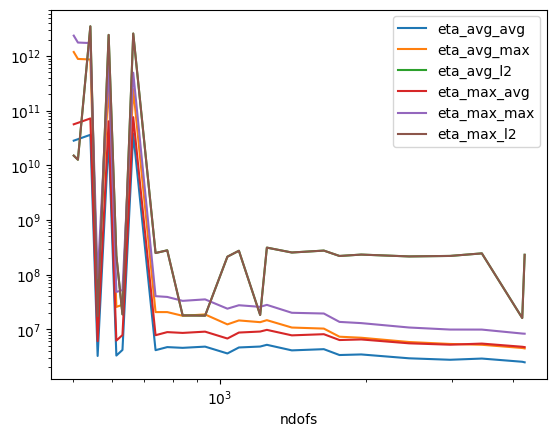

In [25]:
eta_df.plot(x="ndofs", loglog=True)

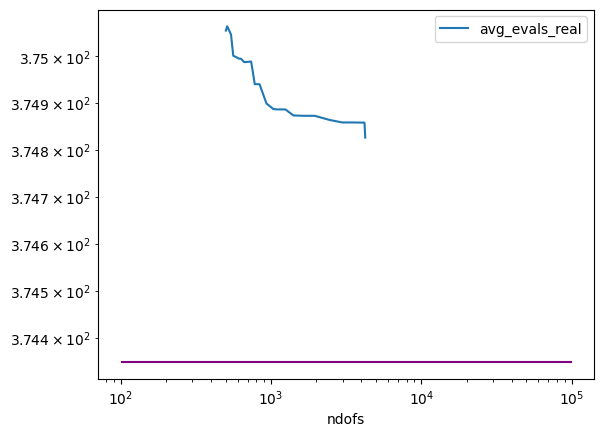

In [26]:
ax = eig_df.drop(["avg_evals", "avg_evals_imag"], axis=1).plot(x="ndofs", loglog=True)
ax.hlines(y=CENTER, xmin=100, xmax=100000, color="purple", label="test")

<Axes: xlabel='ndofs'>

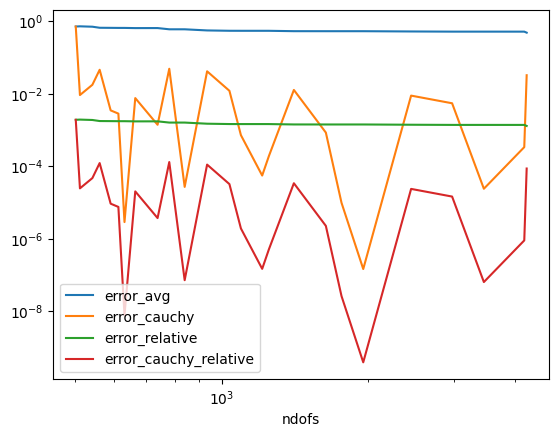

In [27]:
err_df.plot(x="ndofs", loglog=True)

### Arnoldi solver

We also use an Arnoldi type of solver.

In [28]:
matrix = CoefficientFunction((1, 0, 0, 1), dims=(2, 2))
vector = CoefficientFunction((20, 30))
scalar = CoefficientFunction(0.0)
mesh = Mesh(make_unit_square().GenerateMesh(maxh=MAXH))

eta_dict = {}
eig_dict = {}
err_dict = {}
prev_avg_eig = CENTER
iteration = 0
while iteration < MAXITER:
    iteration += 1
    a, m, f, fes = get_forms(
        mesh,
        matrix_coeff=matrix,
        vector_coeff=vector,
        scalar_coeff=scalar,
        order=ORDER,
        is_complex=True,
    )
    right, evals = solve_eigenvalue_arnoldi(a, m, fes, center=CENTER)
    etas = []
    for k in range(len(right.vecs)):
        temp = GridFunction(fes, name="Eigenfunctions")
        temp.vec.data = right.vecs[k]
        eta, _, _ = error_estimator_landscape(
            temp,
            matrix_coeff=matrix,
            vector_coeff=vector,
            scalar_coeff=scalar,
            source_coeff=evals[k] * temp,
        )
        etas.append(eta)
    stacked_etas = np.stack(etas)
    average_etas = np.mean(stacked_etas, axis=0)
    maximum_etas = np.maximum.reduce(stacked_etas)
    append_to_dict(
        eta_dict,
        ndofs=fes.ndof,
        eta_avg_avg=np.mean(average_etas),
        eta_avg_max=np.max(average_etas),
        eta_avg_l2=np.linalg.norm(eta),
        eta_max_avg=np.mean(maximum_etas),
        eta_max_max=np.max(maximum_etas),
        eta_max_l2=np.linalg.norm(eta),
    )
    append_to_dict(
        eig_dict,
        ndofs=fes.ndof,
        avg_evals=np.mean(evals),
        avg_evals_real=np.real(np.mean(evals)),
        avg_evals_imag=np.imag(np.mean(evals)),
    )
    append_to_dict(
        err_dict,
        ndofs=fes.ndof,
        error_avg=np.absolute(np.mean(evals) - CENTER),
        error_cauchy=np.absolute(np.mean(evals) - prev_avg_eig),
        error_relative=np.absolute(np.mean(evals) - CENTER) / np.absolute(CENTER),
        error_cauchy_relative=np.absolute(np.mean(evals) - prev_avg_eig)
        / np.absolute(prev_avg_eig),
    )
    prev_avg_eig = np.mean(evals)
    # Mark
    mark(mesh, eta, theta=THETA)
    # Refine
    mesh.Refine()

In [29]:
a, _, f, fes = get_forms(
    mesh,
    matrix_coeff=matrix,
    vector_coeff=vector,
    scalar_coeff=scalar,
    order=ORDER,
    is_complex=True,
)
u = solve(a, f, fes)
Draw(u, mesh, name="Landscape solution")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [30]:
to_file(eta_dict, "etas_eig_arnoldi.csv")
to_file(eig_dict, "eval_eig_arnoldi.csv")
to_file(err_dict, "errs_eig_arnoldi.csv")
eta_df = pd.DataFrame(eta_dict)
eig_df = pd.DataFrame(eig_dict)
err_df = pd.DataFrame(err_dict)

<Axes: xlabel='ndofs'>

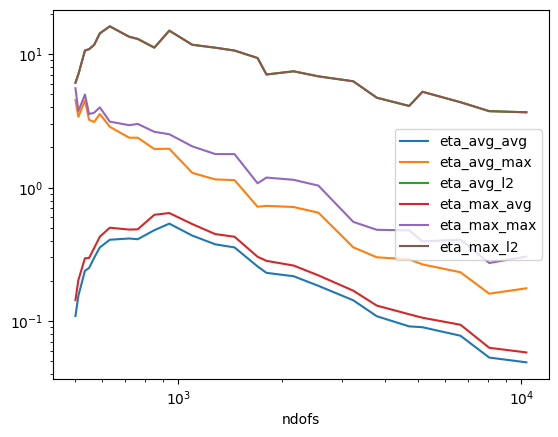

In [31]:
eta_df.plot(x="ndofs", loglog=True)

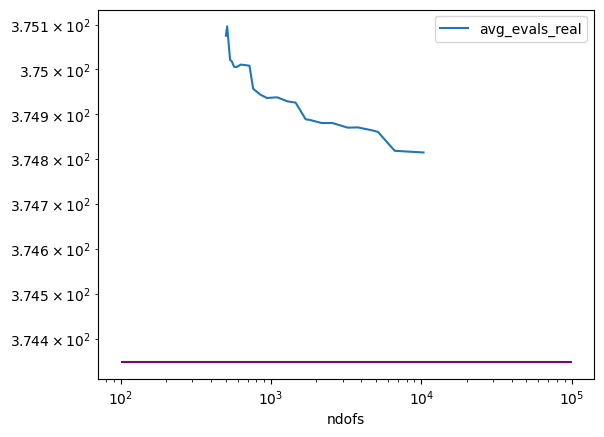

In [32]:
ax = eig_df.drop(["avg_evals", "avg_evals_imag"], axis=1).plot(x="ndofs", loglog=True)
ax.hlines(y=CENTER, xmin=100, xmax=100000, color="purple", label="test")

<Axes: xlabel='ndofs'>

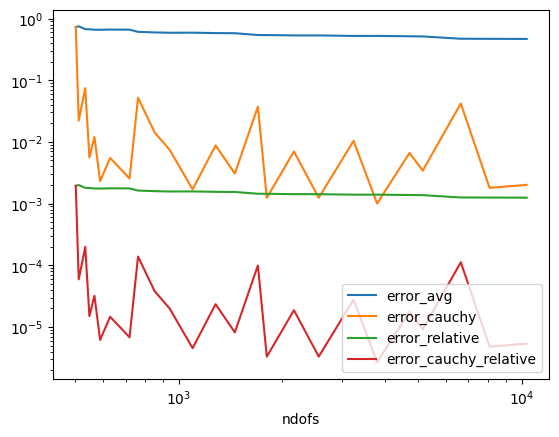

In [33]:
err_df.plot(x="ndofs", loglog=True)

## System 4
Consider the eigenvalue problem
\\[ \tilde{\mathcal{L}} w := -\Delta\ w + \frac{20^2 + 30^2}{4} w  = \lambda w,\\]
with a residual error estimator based on the eigenfunctions.

They have the form
\\[\eta^2_K(w_i, \lambda_i) = \lVert -\Delta\ w_i+  \frac{20^2 + 30^2}{4}w  - \lambda_i w_i\rVert_K^2
    + \frac{1}{2} \lVert \partial_\nu w \rVert_{\partial K}^2. \\]


In [34]:
matrix = CoefficientFunction((1, 0, 0, 1), dims=(2, 2))
vector = CoefficientFunction((0.0, 0.0))
scalar = CoefficientFunction(325.0)
mesh = Mesh(make_unit_square().GenerateMesh(maxh=MAXH))

eta_dict = {}
eig_dict = {}
err_dict = {}
prev_avg_eig = CENTER
iteration = 0
while iteration < MAXITER:
    iteration += 1
    a, m, f, fes = get_forms(
        mesh,
        matrix_coeff=matrix,
        vector_coeff=vector,
        scalar_coeff=scalar,
        order=ORDER,
        is_complex=True,
    )
    right, _, evals = solve_eigenvalue(a, m, fes, center=CENTER)
    etas = []
    for k in range(right.m):
        eta, _, _ = error_estimator_landscape(
            right[k],
            matrix_coeff=matrix,
            vector_coeff=vector,
            scalar_coeff=scalar,
            source_coeff=evals[k] * right[k],
        )
        etas.append(eta)
    stacked_etas = np.stack(etas)
    average_etas = np.mean(stacked_etas, axis=0)
    maximum_etas = np.maximum.reduce(stacked_etas)
    append_to_dict(
        eta_dict,
        ndofs=fes.ndof,
        eta_avg_avg=np.mean(average_etas),
        eta_avg_max=np.max(average_etas),
        eta_avg_l2=np.linalg.norm(eta),
        eta_max_avg=np.mean(maximum_etas),
        eta_max_max=np.max(maximum_etas),
        eta_max_l2=np.linalg.norm(eta),
    )
    append_to_dict(
        eig_dict,
        ndofs=fes.ndof,
        avg_evals=np.mean(evals),
        avg_evals_real=np.real(np.mean(evals)),
        avg_evals_imag=np.imag(np.mean(evals)),
    )
    append_to_dict(
        err_dict,
        ndofs=fes.ndof,
        error_avg=np.absolute(np.mean(evals) - CENTER),
        error_cauchy=np.absolute(np.mean(evals) - prev_avg_eig),
        error_relative=np.absolute(np.mean(evals) - CENTER) / np.absolute(CENTER),
        error_cauchy_relative=np.absolute(np.mean(evals) - prev_avg_eig)
        / np.absolute(prev_avg_eig),
    )
    prev_avg_eig = np.mean(evals)
    # Mark
    mark(mesh, eta, theta=THETA)
    # Refine
    mesh.Refine()


SpectralProj: Setting shifted trapezoidal rule quadrature on circular contour
SpectralProj: Radius=0.01, Center=374.348+0j

SpectralProjNG: Computing resolvents using umfpack
SpectralProjNG:   Factorizing at z = +374.355 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 -0.007j
SpectralProjNG:   Factorizing at z = +374.355 -0.007j

=========== Starting FEAST iterations ===========
Trying with 2 vectors:

 ITERATION 1 with 2 vectors and 2 left vectors
   During kernel cleaning abs(g):
   [3.2e-05 6.8e-04]
   Real part of computed eigenvalues:
   [374.35759663 374.35851288]
   Relative Hausdorff distance from prior iterate: 2.671e+97

 ITERATION 2 with 2 vectors and 2 left vectors
   During kernel cleaning abs(g):
   [3783.4  323.1]
   Real part of computed eigenvalues:
   [374.35759663 374.35851288]
   Relative Hausdorff distance from prior iterate: 1.216e-15


***FEAST converged with:
	Relative Hausdorff distance = 1.216e-15

=

In [35]:
a, _, f, fes = get_forms(
    mesh,
    matrix_coeff=matrix,
    vector_coeff=vector,
    scalar_coeff=scalar,
    order=ORDER,
    is_complex=True,
)
u = solve(a, f, fes)
Draw(u, mesh, name="Landscape solution")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [36]:
to_file(eta_dict, "etas_eig_mod.csv")
to_file(eig_dict, "eval_eig_mod.csv")
to_file(err_dict, "errs_eig_mod.csv")
eta_df = pd.DataFrame(eta_dict)
eig_df = pd.DataFrame(eig_dict)
err_df = pd.DataFrame(err_dict)

<Axes: xlabel='ndofs'>

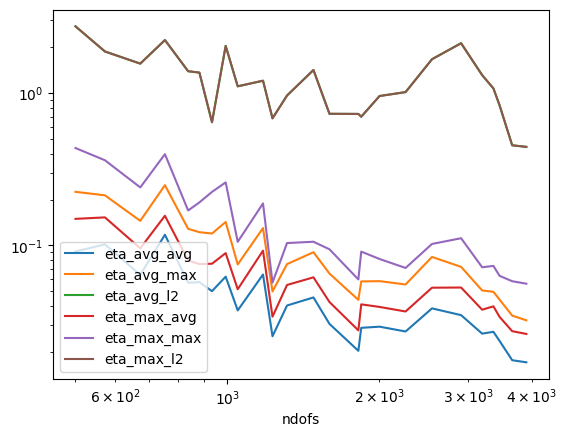

In [37]:
eta_df.plot(x="ndofs", loglog=True)

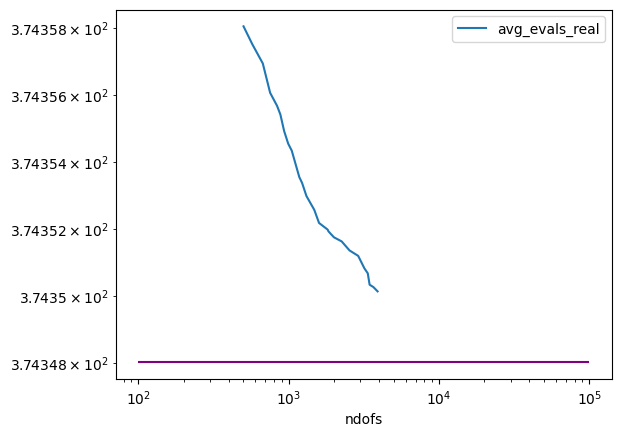

In [38]:
ax = eig_df.drop(["avg_evals", "avg_evals_imag"], axis=1).plot(x="ndofs", loglog=True)
ax.hlines(y=CENTER, xmin=100, xmax=100000, color="purple", label="test")

<Axes: xlabel='ndofs'>

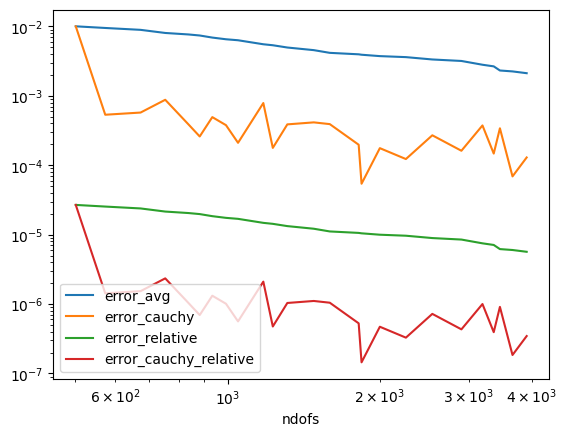

In [39]:
err_df.plot(x="ndofs", loglog=True)

### Arnoldi

In [40]:
matrix = CoefficientFunction((1, 0, 0, 1), dims=(2, 2))
vector = CoefficientFunction((0.0, 0.0))
scalar = CoefficientFunction(325.0)
mesh = Mesh(make_unit_square().GenerateMesh(maxh=MAXH))

eta_dict = {}
eig_dict = {}
err_dict = {}
prev_avg_eig = CENTER
iteration = 0
while iteration < MAXITER:
    iteration += 1
    a, m, f, fes = get_forms(
        mesh,
        matrix_coeff=matrix,
        vector_coeff=vector,
        scalar_coeff=scalar,
        order=ORDER,
        is_complex=True,
    )
    right, evals = solve_eigenvalue_arnoldi(a, m, fes, center=CENTER)
    etas = []
    for k in range(len(right.vecs)):
        temp = GridFunction(fes, name="Eigenfunctions")
        temp.vec.data = right.vecs[k]
        eta, _, _ = error_estimator_landscape(
            temp,
            matrix_coeff=matrix,
            vector_coeff=vector,
            scalar_coeff=scalar,
            source_coeff=evals[k] * temp,
        )
        etas.append(eta)
    stacked_etas = np.stack(etas)
    average_etas = np.mean(stacked_etas, axis=0)
    maximum_etas = np.maximum.reduce(stacked_etas)
    append_to_dict(
        eta_dict,
        ndofs=fes.ndof,
        eta_avg_avg=np.mean(average_etas),
        eta_avg_max=np.max(average_etas),
        eta_avg_l2=np.linalg.norm(eta),
        eta_max_avg=np.mean(maximum_etas),
        eta_max_max=np.max(maximum_etas),
        eta_max_l2=np.linalg.norm(eta),
    )
    append_to_dict(
        eig_dict,
        ndofs=fes.ndof,
        avg_evals=np.mean(evals),
        avg_evals_real=np.real(np.mean(evals)),
        avg_evals_imag=np.imag(np.mean(evals)),
    )
    append_to_dict(
        err_dict,
        ndofs=fes.ndof,
        error_avg=np.absolute(np.mean(evals) - CENTER),
        error_cauchy=np.absolute(np.mean(evals) - prev_avg_eig),
        error_relative=np.absolute(np.mean(evals) - CENTER) / np.absolute(CENTER),
        error_cauchy_relative=np.absolute(np.mean(evals) - prev_avg_eig)
        / np.absolute(prev_avg_eig),
    )
    prev_avg_eig = np.mean(evals)
    # Mark
    mark(mesh, eta, theta=THETA)
    # Refine
    mesh.Refine()

In [41]:
to_file(eta_dict, "etas_eig_mod_arnoldi.csv")
to_file(eig_dict, "eval_eig_mod_arnoldi.csv")
to_file(err_dict, "errs_eig_mod_arnoldi.csv")
eta_df = pd.DataFrame(eta_dict)
eig_df = pd.DataFrame(eig_dict)
err_df = pd.DataFrame(err_dict)

<Axes: xlabel='ndofs'>

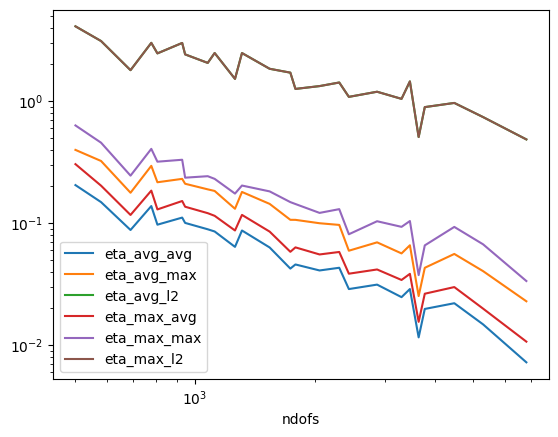

In [42]:
eta_df.plot(x="ndofs", loglog=True)

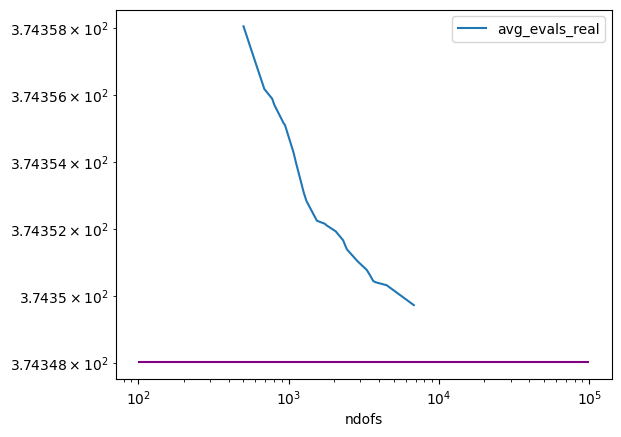

In [43]:
ax = eig_df.drop(["avg_evals", "avg_evals_imag"], axis=1).plot(x="ndofs", loglog=True)
ax.hlines(y=CENTER, xmin=100, xmax=100000, color="purple", label="test")

<Axes: xlabel='ndofs'>

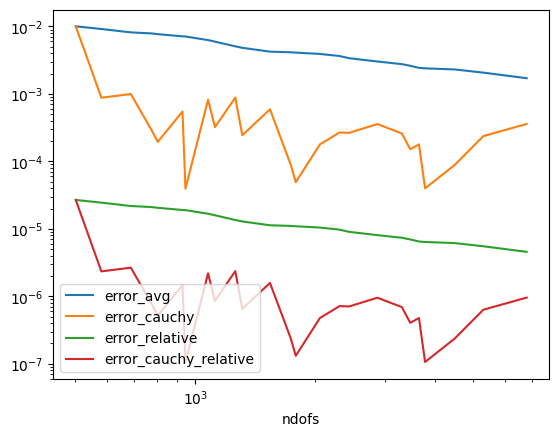

In [44]:
err_df.plot(x="ndofs", loglog=True)

## System 5

Consider
\\[ \mathcal{L} w := -\Delta\ w + (20,30) \cdot \mathrm{grad}(w)  = 1,\\]
with a residual error estimator based on the *gradient* of the landscape function.

It has the *general* form
\\[\eta^2_K = 
\lVert A \cdot \mathrm{grad} w + \frac{x}{n} \rVert_K^2
+ h_K^2 \lVert b \cdot \mathrm{grad} w + c w \rVert_K^2
    + \frac{1}{2} h_k^{1/2} \lVert \frac{x}{n} \cdot \nu \rVert_{\partial K}^2. \\]

In [45]:
matrix = CoefficientFunction((1, 0, 0, 1), dims=(2, 2))
vector = CoefficientFunction((20, 30))
scalar = CoefficientFunction(0.0)
mesh = Mesh(make_unit_square().GenerateMesh(maxh=MAXH))

eta_dict = {}
eig_dict = {}
err_dict = {}
prev_avg_eig = CENTER
iteration = 0
while iteration < MAXITER:
    iteration += 1
    a, m, f, fes = get_forms(
        mesh,
        matrix_coeff=matrix,
        vector_coeff=vector,
        scalar_coeff=scalar,
        order=ORDER,
        is_complex=True,
    )
    u = solve(a, f, fes)
    _, _, evals = solve_eigenvalue(a, m, fes, center=CENTER)
    eta, _, _ = error_estimator_grad_landscape(
        u, matrix_coeff=matrix, vector_coeff=vector, scalar_coeff=scalar
    )
    append_to_dict(
        eta_dict,
        ndofs=fes.ndof,
        eta_avg=np.mean(eta),
        eta_l2=np.linalg.norm(eta),
        eta_max=np.max(eta),
    )
    append_to_dict(
        eig_dict,
        ndofs=fes.ndof,
        avg_evals=np.mean(evals),
        avg_evals_real=np.real(np.mean(evals)),
        avg_evals_imag=np.imag(np.mean(evals)),
    )
    append_to_dict(
        err_dict,
        ndofs=fes.ndof,
        error_avg=np.absolute(np.mean(evals) - CENTER),
        error_cauchy=np.absolute(np.mean(evals) - prev_avg_eig),
        error_relative=np.absolute(np.mean(evals) - CENTER) / np.absolute(CENTER),
        error_cauchy_relative=np.absolute(np.mean(evals) - prev_avg_eig)
        / np.absolute(prev_avg_eig),
    )
    prev_avg_eig = np.mean(evals)
    # Mark
    mark(mesh, eta, theta=THETA)
    # Refine
    mesh.Refine()


SpectralProj: Setting shifted trapezoidal rule quadrature on circular contour
SpectralProj: Radius=0.01, Center=374.348+0j

SpectralProjNG: Computing resolvents using umfpack
SpectralProjNG:   Factorizing at z = +374.355 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 -0.007j
SpectralProjNG:   Factorizing at z = +374.355 -0.007j

=========== Starting FEAST iterations ===========
Trying with 2 vectors:

 ITERATION 1 with 2 vectors and 2 left vectors
   During kernel cleaning abs(g):
   [1.9e-16 3.8e-10]
   Real part of computed eigenvalues:
   [373.93664014 376.17301055]
   Imag part of computed eigenvalues:
   [-1.14895821e-13 -3.16204655e-09]
   Relative Hausdorff distance from prior iterate: 2.671e+97

 ITERATION 2 with 2 vectors and 2 left vectors
   During kernel cleaning abs(g):
   [1.3e-05 3.1e-04]
   Real part of computed eigenvalues:
   [373.93664014 376.17301055]
   Relative Hausdorff distance from prior iterate: 1.9

In [46]:
Draw(u, mesh, name="Landscape function")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [47]:
to_file(eta_dict, "etas_grad_problem.csv")
to_file(eig_dict, "eval_grad_problem.csv")
to_file(err_dict, "errs_grad_problem.csv")
eta_df = pd.DataFrame(eta_dict)
eig_df = pd.DataFrame(eig_dict)
err_df = pd.DataFrame(err_dict)

<Axes: xlabel='ndofs'>

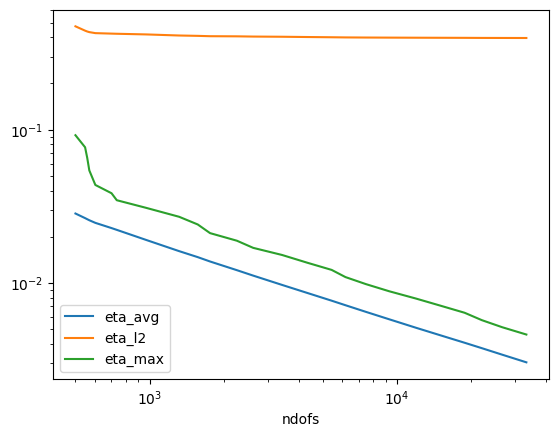

In [48]:
eta_df.plot(x="ndofs", loglog=True)

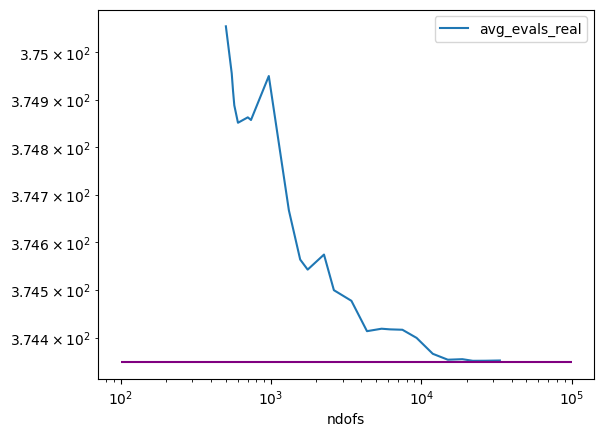

In [49]:
ax = eig_df.drop(["avg_evals", "avg_evals_imag"], axis=1).plot(x="ndofs", loglog=True)
ax.hlines(y=CENTER, xmin=100, xmax=100000, color="purple", label="test")

<Axes: xlabel='ndofs'>

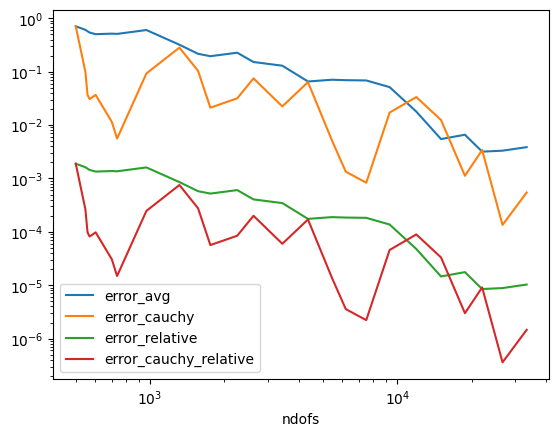

In [50]:
err_df.plot(x="ndofs", loglog=True)

## System 6

In [51]:
matrix = CoefficientFunction((1, 0, 0, 1), dims=(2, 2))
vector = CoefficientFunction((0.0, 0.0))
scalar = CoefficientFunction(325.0)
mesh = Mesh(make_unit_square().GenerateMesh(maxh=MAXH))

eta_dict = {}
eig_dict = {}
err_dict = {}
prev_avg_eig = CENTER
iteration = 0
while iteration < MAXITER:
    iteration += 1
    a, m, f, fes = get_forms(
        mesh,
        matrix_coeff=matrix,
        vector_coeff=vector,
        scalar_coeff=scalar,
        order=ORDER,
        is_complex=True,
    )
    u = solve(a, f, fes)
    _, _, evals = solve_eigenvalue(a, m, fes, center=CENTER)
    eta, _, _ = error_estimator_grad_landscape(
        u, matrix_coeff=matrix, vector_coeff=vector, scalar_coeff=scalar
    )
    append_to_dict(
        eta_dict,
        ndofs=fes.ndof,
        eta_avg=np.mean(eta),
        eta_l2=np.linalg.norm(eta),
        eta_max=np.max(eta),
    )
    append_to_dict(
        eig_dict,
        ndofs=fes.ndof,
        avg_evals=np.mean(evals),
        avg_evals_real=np.real(np.mean(evals)),
        avg_evals_imag=np.imag(np.mean(evals)),
    )
    append_to_dict(
        err_dict,
        ndofs=fes.ndof,
        error_avg=np.absolute(np.mean(evals) - CENTER),
        error_cauchy=np.absolute(np.mean(evals) - prev_avg_eig),
        error_relative=np.absolute(np.mean(evals) - CENTER) / np.absolute(CENTER),
        error_cauchy_relative=np.absolute(np.mean(evals) - prev_avg_eig)
        / np.absolute(prev_avg_eig),
    )
    prev_avg_eig = np.mean(evals)
    # Mark
    mark(mesh, eta, theta=THETA)
    # Refine
    mesh.Refine()


SpectralProj: Setting shifted trapezoidal rule quadrature on circular contour
SpectralProj: Radius=0.01, Center=374.348+0j

SpectralProjNG: Computing resolvents using umfpack
SpectralProjNG:   Factorizing at z = +374.355 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 -0.007j
SpectralProjNG:   Factorizing at z = +374.355 -0.007j

=========== Starting FEAST iterations ===========
Trying with 2 vectors:

 ITERATION 1 with 2 vectors and 2 left vectors
   During kernel cleaning abs(g):
   [3.2e-05 6.8e-04]
   Real part of computed eigenvalues:
   [374.35759663 374.35851288]
   Relative Hausdorff distance from prior iterate: 2.671e+97

 ITERATION 2 with 2 vectors and 2 left vectors
   During kernel cleaning abs(g):
   [3783.4  323.1]
   Real part of computed eigenvalues:
   [374.35759663 374.35851288]
   Relative Hausdorff distance from prior iterate: 1.216e-15


***FEAST converged with:
	Relative Hausdorff distance = 1.216e-15

=

In [52]:
to_file(eta_dict, "etas_grad_problem.csv")
to_file(eig_dict, "eval_grad_problem.csv")
to_file(err_dict, "errs_grad_problem.csv")
eta_df = pd.DataFrame(eta_dict)
eig_df = pd.DataFrame(eig_dict)
err_df = pd.DataFrame(err_dict)

In [53]:
Draw(u, mesh, name="Landscape function")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

<Axes: xlabel='ndofs'>

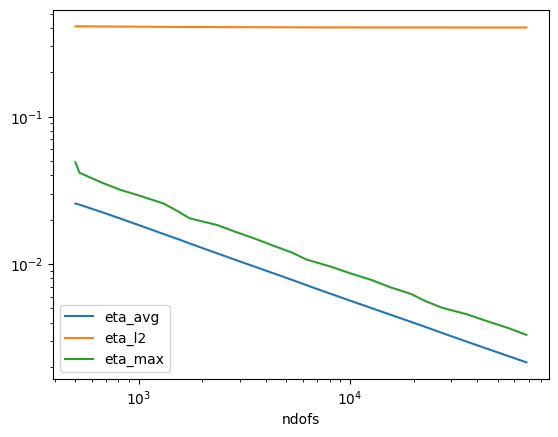

In [54]:
eta_df.plot(x="ndofs", loglog=True)

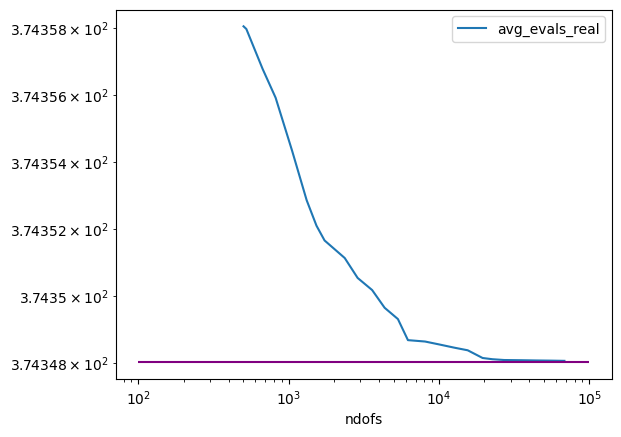

In [55]:
ax = eig_df.drop(["avg_evals", "avg_evals_imag"], axis=1).plot(x="ndofs", loglog=True)
ax.hlines(y=CENTER, xmin=100, xmax=100000, color="purple", label="test")

<Axes: xlabel='ndofs'>

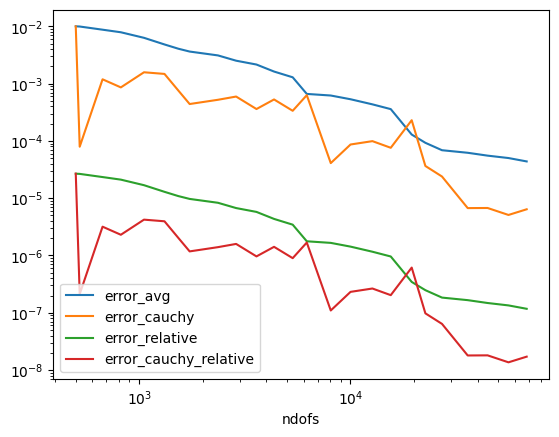

In [56]:
err_df.plot(x="ndofs", loglog=True)

## Playground: Rotational invariance
Consider the exponential potential
\\( \exp(10 x + 15 y) \\)

In [ ]:
exp_potential_1 = CoefficientFunction(exp(10 * x + 15 * y))
# exp_potential_2 = CoefficientFunction(exp(-10 * x - 15 * y))
# exp_potential_3 = CoefficientFunction(exp(10 * x + 15 * y))
# exp_potential_4 = CoefficientFunction(exp(-10 * x - 15 * y))

In [ ]:
u_1 = exp_potential_1 * u
# u_2 = exp_potential_2 * u
# u_3 = exp_potential_3 * u
# u_4 = exp_potential_4 * u
Draw(u_1, mesh, name="u1")
# Draw(u_2, mesh, name="u1")
# Draw(u_3, mesh, name="u1")
# Draw(u_4, mesh, name="u1")

In [ ]:
for n in range(1, 5):
    exp_potential = CoefficientFunction(
        exp(exp(2 * np.pi / n * 1j) * (10 * x + 15 * y))
    )
    u_ = u * exp_potential
    Draw(u_, mesh, name="Shifted u")